In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
train_dir = '/kaggle/input/dl-63-cw-image-classification/train'
test_dir = '/kaggle/input/dl-63-cw-image-classification/test'
train_csv = '/kaggle/input/dl-63-cw-image-classification/train.csv'
test_csv = '/kaggle/input/dl-63-cw-image-classification/test.csv'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [3]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image size and batch size
img_size = (224, 224)  # Resized 
batch_size = 32

# Create an instance of ImageDataGenerator for training with random augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,     # Randomly translate images horizontally
    height_shift_range=0.2,    # Randomly translate images vertically
    shear_range=0.2,           # Randomly apply shearing transformations
    zoom_range=0.2,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest',        # Fill new pixels that may appear after transformations
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
)

# Create an instance of ImageDataGenerator for validation (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Set up the training data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filepaths',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Set up the validation data generator
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=train_dir,
    x_col='filepaths',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Set up the test data generator (without augmentation)
test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filepaths',
    y_col=None, 
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)


Found 6356 validated image filenames belonging to 70 classes.
Found 1590 validated image filenames belonging to 70 classes.
Found 1400 validated image filenames.


In [4]:
# input_tensor = Input(shape=(224, 224, 3))
# base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)

# for layer in base_model.layers[:-20]:  
#     layer.trainable = False

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define input shape
input_shape = (224, 224, 3)  # Or (224, 224, 3) based on your choice

# Load InceptionV3 and Xception with ImageNet weights and without the top fully connected layers
inception_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base models (optional, or you can fine-tune some layers)
for layer in inception_base.layers[:-10]:
    layer.trainable = False

for layer in xception_base.layers[:-10]:
    layer.trainable = False
    
# Create custom input tensor
input_tensor = Input(shape=input_shape)

# Pass the input through both models
xception_features = xception_base(input_tensor)
inception_features = inception_base(input_tensor)

# Global average pooling for both feature sets
xception_pooling = GlobalAveragePooling2D()(xception_features)
inception_pooling = GlobalAveragePooling2D()(inception_features)

# Concatenate the features
merged = Concatenate()([xception_pooling, inception_pooling])

# Add the custom MLP on top of the concatenated features
# x = Dropout(0.3)(merged)
x = Dense(512, activation='relu')(merged)
x = Dropout(0.3)(x)

# Output layer (for 70 classes with sigmoid activation)
output_tensor = Dense(70, activation='softmax')(x)

# Create the hybrid model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Show model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 7, 7,      │ 20,861,480 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,311,232 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 70)        │     35,910 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,923,310 (140.85 MB)

 Trainable params: 20,412,742 (77.87 MB)

 Non-trainable params: 16,510,568 (62.98 MB)

In [6]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40, 
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727629032.639750      64 service.cc:145] XLA service 0x7a9c400118e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727629032.639829      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/199 ━━━━━━━━━━━━━━━━━━━━ 1:49:40 33s/step - accuracy: 0.0000e+00 - loss: 4.3954

I0000 00:00:1727629053.937332      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 171s 697ms/step - accuracy: 0.3832 - loss: 3.0317 - val_accuracy: 0.9069 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 2/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 92s 446ms/step - accuracy: 0.8534 - loss: 0.5493 - val_accuracy: 0.9264 - val_loss: 0.2655 - learning_rate: 1.0000e-04
Epoch 3/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 90s 440ms/step - accuracy: 0.8980 - loss: 0.3581 - val_accuracy: 0.9157 - val_loss: 0.2662 - learning_rate: 1.0000e-04
Epoch 4/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 140s 429ms/step - accuracy: 0.8991 - loss: 0.3149 - val_accuracy: 0.9189 - val_loss: 0.2540 - learning_rate: 1.0000e-04
Epoch 5/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 90s 436ms/step - accuracy: 0.9104 - loss: 0.2856 - val_accuracy: 0.9214 - val_loss: 0.2513 - learning_rate: 1.0000e-04
Epoch 6/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 89s 434ms/step - accuracy: 0.9290 - loss: 0.2223 - val_accuracy: 0.9258 - val_loss: 0.2546 - learning_rate: 1.0000e-04
Epoch 7/40
199/199 ━━━━━━━━━━━━━━━━━━━━ 92s 448ms/step 

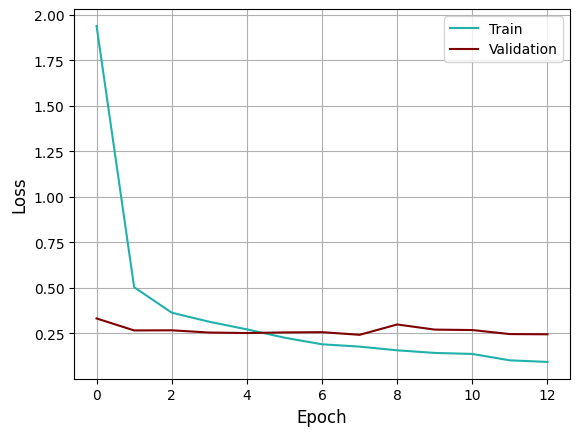

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Lấy dữ liệu loss và val_loss từ lịch sử huấn luyện
loss = pd.DataFrame({
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss']
})

# Vẽ biểu đồ loss
ax = loss[["loss", "val_loss"]].plot(color=['lightseagreen', 'maroon'])

# Thiết lập nhãn trục x, y
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Thêm legend
ax.legend(['Train', 'Validation'], fontsize=10)

# Hiển thị lưới
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

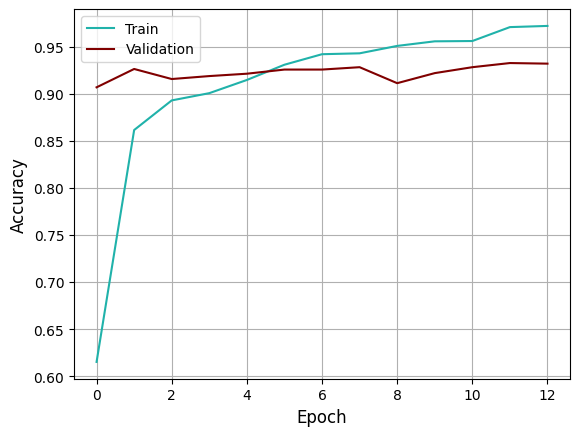

In [8]:
# Lấy dữ liệu accuracy và val_accuracy từ lịch sử huấn luyện
accuracy = pd.DataFrame({
    "accuracy": history.history['accuracy'],
    "val_accuracy": history.history['val_accuracy']
})

# Vẽ biểu đồ accuracy
ax = accuracy[["accuracy", "val_accuracy"]].plot(color=['lightseagreen', 'maroon'])

# Thiết lập nhãn trục x, y
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)

# Thêm legend
ax.legend(['Train', 'Validation'], fontsize=10)

# Hiển thị lưới
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [9]:
# Combine train and validation data
combined_df = pd.concat([train_df, val_df])

# Create a new data generator for the combined dataset
combined_generator = train_datagen.flow_from_dataframe(
    combined_df,
    directory=train_dir,
    x_col='filepaths',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7946 validated image filenames belonging to 70 classes.


In [10]:
# Adjust the learning rate for fine-tuning
fine_tune_lr = 1e-5  # Smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Continue training on the combined dataset
history_combined = model.fit(
    combined_generator,
    epochs=10,  # Fine-tuning for a few epochs (adjust as needed)
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 126s 447ms/step - accuracy: 0.9444 - loss: 0.1831 - learning_rate: 1.0000e-05
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 105s 409ms/step - accuracy: 0.9449 - loss: 0.1824 - learning_rate: 1.0000e-05
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 403ms/step - accuracy: 0.9523 - loss: 0.1704 - learning_rate: 1.0000e-05
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 403ms/step - accuracy: 0.9519 - loss: 0.1585 - learning_rate: 1.0000e-05
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 105s 410ms/step - accuracy: 0.9507 - loss: 0.1573 - learning_rate: 1.0000e-05
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 402ms/step - accuracy: 0.9551 - loss: 0.1478 - learning_rate: 1.0000e-05
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 404ms/step - accuracy: 0.9524 - loss: 0.1517 - learning_rate: 1.0000e-05
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 400ms/step - accuracy: 0.9551 - loss: 0.1416 - learning_rate: 1.0000e-05
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 401ms/step - accuracy: 0.9566 - loss: 0.1429 - learning_rate: 1.0000e-05
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 103s 400ms/step - accuracy

In [11]:
# Dự đoán trên tập test
predictions = model.predict(test_generator)

# predictions sẽ trả về xác suất của các lớp, chúng ta lấy lớp có xác suất cao nhất
predicted_classes = predictions.argmax(axis=-1)

# Lấy danh sách các lớp từ class_indices của train_generator
class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Tạo từ điển ngược

# Chuyển các chỉ số predicted_classes thành nhãn lớp thực tế
predicted_labels = [class_labels[idx] for idx in predicted_classes]

# In ra nhãn lớp dự đoán
print(predicted_labels)

44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step
['class_58', 'class_58', 'class_7', 'class_17', 'class_71', 'class_39', 'class_69', 'class_36', 'class_27', 'class_31', 'class_34', 'class_69', 'class_36', 'class_57', 'class_70', 'class_39', 'class_50', 'class_39', 'class_63', 'class_3', 'class_55', 'class_53', 'class_41', 'class_12', 'class_14', 'class_63', 'class_34', 'class_19', 'class_5', 'class_7', 'class_46', 'class_23', 'class_33', 'class_56', 'class_42', 'class_19', 'class_21', 'class_31', 'class_52', 'class_55', 'class_59', 'class_48', 'class_6', 'class_32', 'class_18', 'class_13', 'class_4', 'class_23', 'class_46', 'class_35', 'class_20', 'class_8', 'class_59', 'class_60', 'class_17', 'class_59', 'class_35', 'class_27', 'class_49', 'class_16', 'class_69', 'class_45', 'class_71', 'class_17', 'class_13', 'class_8', 'class_20', 'class_69', 'class_71', 'class_38', 'class_63', 'class_11', 'class_32', 'class_65', 'class_23', 'class_38', 'class_64', 'class_65', 'class_61', 'class_26', 'clas

In [12]:
predictions

array([[1.1493662e-06, 2.2912698e-06, 2.1052058e-06, ..., 7.8276798e-07,
        9.8487567e-07, 2.6779574e-07],
       [3.7151341e-07, 1.4672413e-06, 9.2880975e-07, ..., 2.2765326e-07,
        7.0212548e-07, 1.2795157e-07],
       [1.6508405e-06, 2.1041919e-02, 2.9356241e-05, ..., 3.7742970e-07,
        2.0762059e-06, 6.4028964e-06],
       ...,
       [1.2748184e-07, 6.9448140e-07, 2.9574881e-07, ..., 3.8262303e-07,
        3.3376156e-07, 2.8505062e-06],
       [1.7182088e-05, 1.3007189e-05, 1.8141569e-05, ..., 1.6042851e-06,
        4.5576653e-06, 1.6028989e-05],
       [9.7935481e-07, 6.4059036e-06, 3.8932723e-07, ..., 3.2690414e-07,
        1.7316637e-05, 1.8626588e-06]], dtype=float32)

In [13]:
test_df['TARGET'] = predicted_labels
test_df = test_df.drop(columns=['filepaths'])
# test_df['TARGET'] = 'class_' + test_df['TARGET'].astype(str)
test_df.head()

,ID,TARGET
0,0,class_58
1,1,class_58
2,2,class_7
3,3,class_17
4,4,class_71


In [14]:
from IPython.display import HTML
test_df.to_csv('MultiLP_hybrid_v7.csv', index=False)
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='MultiLP_hybrid_v7.csv')

In [15]:
accuracy.iloc[-1]

accuracy        0.972152
val_accuracy    0.932076
Name: 12, dtype: float64